# NBA: Prediction of Game Winners

NBA is the second most popular sport in North America. Being able to predict game result is important for general managers of each team especially closer to the end of a season. They can use that to decide if they have a shot to the playoffs or if they can rest their star players to avoid them getting injured. And for teams that are making it to playoffs, it's very important for them to predict game results to see which seeds they are likely to be. Also, NBA attracts many people to bet on the game so the sport betting market is quite huge. Therefore, it's interesting to know if we can find a way to **beat the house.**

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report

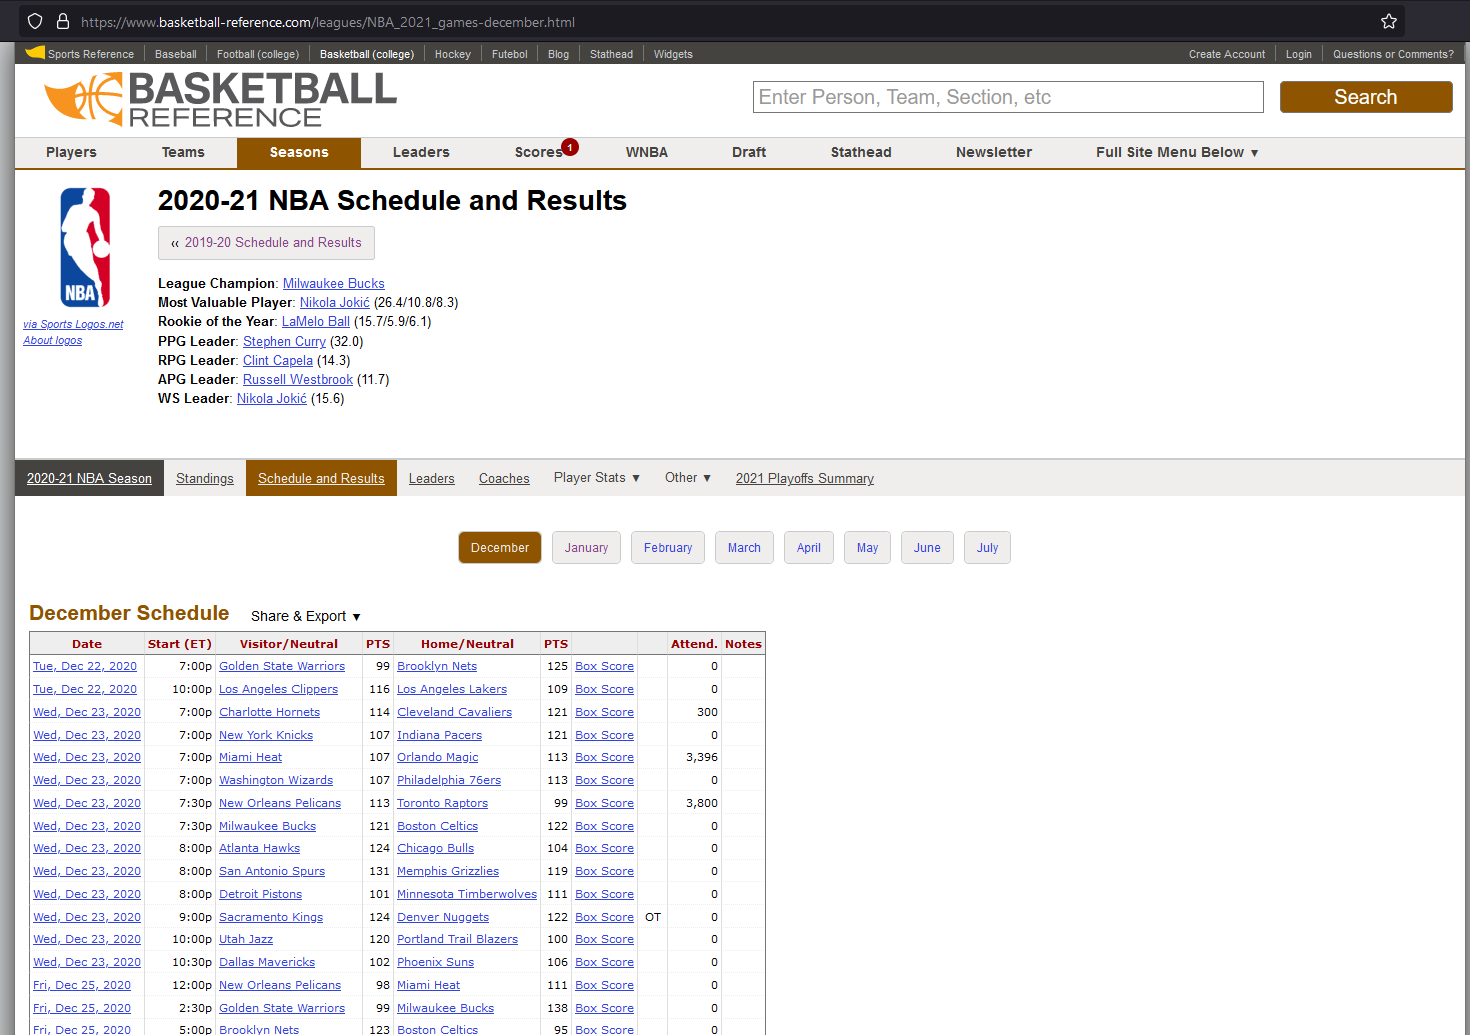

The data was pulled from https://www.basketball-reference.com/ like the picture above. I clicked on "Share & Export" to get a tabke for each month and I put them as a csv file.

In [2]:
# Import 2019-2020 season result into a dataframe.
# A season normally starts in Octorber and ends in June. In the last few years there were some disruption so the schedule was
# messed up. Please noice season 2019-2020 is just one season since it crossed two years. 

NBA_19_20_df = pd.read_csv('./datasets/NBA Regular Season Results 2019-2020.csv', parse_dates = ['Date'])
# started a scorer using f1 score
scorer = make_scorer(f1_score, pos_label = None, average = 'weighted')
NBA_19_20_df.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,2019-10-22,8:00p,New Orleans Pelicans,122,Toronto Raptors,130,Box Score,OT,20787.0,NaN
1,2019-10-22,10:30p,Los Angeles Lakers,102,Los Angeles Clippers,112,Box Score,NaN,19068.0,NaN
2,2019-10-23,7:00p,Chicago Bulls,125,Charlotte Hornets,126,Box Score,NaN,15424.0,NaN
3,2019-10-23,7:00p,Detroit Pistons,119,Indiana Pacers,110,Box Score,NaN,17923.0,NaN
4,2019-10-23,7:00p,Cleveland Cavaliers,85,Orlando Magic,94,Box Score,NaN,18846.0,NaN


In [5]:
# Update column names 

NBA_19_20_df.columns = ['Date', 'Start_Time', 'Visitor_Team', 'Visitor_Score', 'Home_Team', 'Home_Score', 'Box_Score', 
              'OT', 'Attendance', 'Notes']
NBA_19_20_df.head()

,Date,Start_Time,Visitor_Team,Visitor_Score,Home_Team,Home_Score,Box_Score,OT,Attendance,Notes
0,2019-10-22,8:00p,New Orleans Pelicans,122,Toronto Raptors,130,Box Score,OT,20787.0,NaN
1,2019-10-22,10:30p,Los Angeles Lakers,102,Los Angeles Clippers,112,Box Score,NaN,19068.0,NaN
2,2019-10-23,7:00p,Chicago Bulls,125,Charlotte Hornets,126,Box Score,NaN,15424.0,NaN
3,2019-10-23,7:00p,Detroit Pistons,119,Indiana Pacers,110,Box Score,NaN,17923.0,NaN
4,2019-10-23,7:00p,Cleveland Cavaliers,85,Orlando Magic,94,Box Score,NaN,18846.0,NaN


In [6]:
NBA_19_20_df.dtypes

Date             datetime64[ns]
Start_Time               object
Visitor_Team             object
Visitor_Score             int64
Home_Team                object
Home_Score                int64
Box_Score                object
OT                       object
Attendance              float64
Notes                    object
dtype: object

In [7]:
NBA_19_20_df.isnull().sum()

Date                0
Start_Time          0
Visitor_Team        0
Visitor_Score       0
Home_Team           0
Home_Score          0
Box_Score           0
OT               1068
Attendance        171
Notes            1139
dtype: int64

In [8]:
NBA_19_20_df.OT.value_counts()

OT     68
2OT     7
Name: OT, dtype: int64

In [9]:
NBA_19_20_df.Notes.value_counts()

at Mexico City Mexico    2
at Paris France          1
Play-In Game             1
Name: Notes, dtype: int64

In [10]:
NBA_19_20_df.Attendance

0       20787.0
1       19068.0
2       15424.0
3       17923.0
4       18846.0
         ...   
1138        NaN
1139        NaN
1140        NaN
1141        NaN
1142        NaN
Name: Attendance, Length: 1143, dtype: float64

In [11]:
NBA_19_20_df.Box_Score.value_counts()

Box Score    1143
Name: Box_Score, dtype: int64

In [12]:
# Modify OT column
# Drop Notes column because there are only 4 non-null values
# Drop Attendance column because due to COVID19 shutdown, the attendance at the end of 2019-2020 season was 0. And the attendance
# in 2020-2021 season was also affected by COVID19
# Drop Box_Score because it only has one value

NBA_19_20_df.OT = NBA_19_20_df.OT.apply(lambda x: 2 if x=='2OT' else (1 if x=='OT' else 0))
NBA_19_20_df.drop(['Attendance', 'Notes', 'Box_Score'], axis=1, inplace = True)

In [13]:
# Add a new feature that reflects if  home team won

NBA_19_20_df['Home_Win'] =  NBA_19_20_df['Home_Score'] > NBA_19_20_df['Visitor_Score']
y_true = NBA_19_20_df['Home_Win'].values

In [33]:
# Setting up a dictionary to record win/lose record for each team

Team_Record_19_20 = {}
for i in set(NBA_19_20_df.Visitor_Team):
    Team_Record_19_20[i] = []

In [34]:
# Adding two new features: Home_Win_Last & Visitor_Win_Last to see if home or visitor team won the last game

NBA_19_20_df['Home_Win_Last'] = 'N/A'
NBA_19_20_df['Visitor_Win_Last'] = 'N/A'

for index, row in NBA_19_20_df.iterrows():
    # Home_Team won last
    if len(Team_Record_19_20[row['Home_Team']])==0:
        NBA_19_20_df.at[index,'Home_Win_Last'] = 0
    elif Team_Record_19_20[row['Home_Team']][-1]==0:
        NBA_19_20_df.at[index,'Home_Win_Last'] = 0
    else:
        NBA_19_20_df.at[index,'Home_Win_Last']= 1
    # Visitor_Team won last    
    if len(Team_Record_19_20[row['Visitor_Team']])==0:
        NBA_19_20_df.at[index,'Visitor_Win_Last'] = 0
    elif Team_Record_19_20[row['Visitor_Team']][-1]==0:
        NBA_19_20_df.at[index,'Visitor_Win_Last'] = 0
    else:
        NBA_19_20_df.at[index,'Visitor_Win_Last']= 1
    # Adding to Team_Record    
    if row['Home_Win']:
        Team_Record_19_20[row['Home_Team']].append(1)
        Team_Record_19_20[row['Visitor_Team']].append(0)
    else:
        Team_Record_19_20[row['Visitor_Team']].append(1)
        Team_Record_19_20[row['Home_Team']].append(0)

In [39]:
# Look at some of the Utah Jazz record to see if our features were recorded correctly

NBA_19_20_df[(NBA_19_20_df.Visitor_Team == 'Utah Jazz')|(NBA_19_20_df.Home_Team == 'Utah Jazz')].iloc[60:78]

,Date,Start_Time,Visitor_Team,Visitor_Score,Home_Team,Home_Score,OT,Home_Win,Home_Win_Last,Visitor_Win_Last
919,2020-03-04,7:30p,Utah Jazz,112,New York Knicks,104,0,False,1,1
934,2020-03-06,8:00p,Utah Jazz,99,Boston Celtics,94,0,False,1,1
939,2020-03-07,7:00p,Utah Jazz,111,Detroit Pistons,105,0,False,0,1
957,2020-03-09,9:00p,Toronto Raptors,101,Utah Jazz,92,0,False,1,1
971,2020-07-30,6:30p,Utah Jazz,106,New Orleans Pelicans,104,0,False,1,0
980,2020-08-01,3:30p,Utah Jazz,94,Oklahoma City Thunder,110,0,True,1,1
995,2020-08-03,9:00p,Los Angeles Lakers,116,Utah Jazz,108,0,False,0,0
1002,2020-08-05,2:30p,Memphis Grizzlies,115,Utah Jazz,124,0,True,0,0
1014,2020-08-07,1:00p,Utah Jazz,111,San Antonio Spurs,119,0,True,0,1
1021,2020-08-08,3:30p,Utah Jazz,132,Denver Nuggets,134,2,True,0,0


In [20]:
NBA_19_20_df.Home_Win_Last.value_counts()

0    608
1    535
Name: Home_Win_Last, dtype: int64

______________________________________________________________________________________________________________________